# Extract PSD features with fooof

In [8]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fooof import FOOOFGroup, FOOOF
from fooof.analysis import get_band_peak_fg
from fooof.bands import Bands
from IPython.display import clear_output
from mne.time_frequency import psd_array_welch


In [2]:
#### constant variables to be used in the code ####

# sampling rate
sfreq = 512

# frequency bands of interest
frequencies = {'delta': (1, 4),
               'theta': (4, 8),
               'alpha': (8, 13),
               'beta': (13, 30),
               'lowgamma': (30, 42)  
}
bands = Bands(frequencies)

# labels for the psd table based on Yeo2011 7 networks
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

labels_ = [yeo7[k] + '_' + hemisferes[i] 
           for k in yeo7.keys() 
           for i in range(len(hemisferes))]

In [3]:
#### helper functions to be used in the code ####

# get dataframe of powers for each frequency band
def get_power_bands_df(psds, labels=labels_):
    
    # initiate a dictionary to store power from each band
    psds_bands = {}
    
    # dB scale the power spectrum
    psds_transformed =  10 * np.log10(psds)
    
    # average the power over each band
    for k in frequencies.keys():
        temp = psds_transformed[:, np.where((frequencies[k][0] <= freqs) & (freqs <= frequencies[k][1]) == True)[0]]
        psds_bands[k] = temp.mean(1)
    
    # create and return a dataframe with the power from each band across all networks
    df = pd.DataFrame.from_dict(psds_bands, orient='index', columns=labels).T.stack().reset_index()
    df['new_col'] = df['level_0'] + '_' + df['level_1']
    df.drop(['level_0', 'level_1'], axis=1, inplace=True)
    
    return df.set_index('new_col').T

# get dataframe of the aperiodic components of the power spectrum
def get_aperiodic_components_df(fg, labels=labels_):
    
    # define new labels for the aperiodic components
    aperiodic_params = ['offset', 'exponent']
    labels = [labels_[i] + '_' + aperiodic_params[j] 
            for i in range(len(labels_)) 
            for j in range(len(aperiodic_params))]


    off = fg.get_params('aperiodic_params')
    return pd.DataFrame(np.hstack(off), index=labels).T
    
# get dataframe of Individual Alpha Frequency (IAF)
def get_iaf_df(fg, labels=labels_):
    
    # define new labels for IAF features
    alpha_params = ['IAF_cf', 'IAF_pw']

    labels = [labels_[i] + '_' + alpha_params[j] 
            for i in range(len(labels_)) 
            for j in range(len(alpha_params))]

    # Extract any alpha band peaks from the power spectrum model
    alpha = get_band_peak_fg(fg, bands.alpha)[:, [0, 1]]
    return pd.DataFrame(np.hstack(alpha), index=labels).T

In [174]:
#### extract PSD features on parcellated source data ####

# initialize a dataframe to store PSD features for all subjects
psd_df = pd.DataFrame()

# open the parcellated source data
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):
  
  subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()

  label_ts = np.load(subject_path)['labels']
  
  # create a continuous data array from the parcellated source data
  label_continious = np.hstack(np.array(label_ts))

  # calculate psd on continuous data
  psds, freqs = psd_array_welch(label_continious,
                                sfreq=sfreq,
                                fmin=1,
                                fmax=40,
                                n_fft=2048, # window size is 2048/512 = 4s
                                n_overlap=1024, # 50% overlap
                                n_jobs=1)

  # initialize FOOOF group object
  fg = FOOOFGroup(aperiodic_mode='fixed', # knee is 'fixed' to 0 as our frequency range is not greater than 40 Hz
                  peak_width_limits=[1, 8], # minimum peak width is 1Hz, four time the frequency resolution (0.25Hz)
                  min_peak_height=0.05,
                  peak_threshold=2)

  # fit model
  fg.fit(freqs, psds)

  # extract periodic parameters
  df_periodic = get_power_bands_df(psds)

  # extract aperiodic parameters
  df_aperiodic = get_aperiodic_components_df(fg)

  # extract alpha band peaks
  df_alpha = get_iaf_df(fg)

  # concatenate all dataframes
  df_ = pd.concat([df_periodic, df_aperiodic, df_alpha], axis=1)

  # reindex the dataframe
  index = subject[4:] + '_' + task
  df_.index = [index]
  
  # append to the main dataframe
  psd_df = pd.concat([psd_df, df_], axis=0)
  
  clear_output()

In [189]:
# open behavioral data
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')

# open power data
psd_df[['bids_id', 'condition']] = psd_df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
psd_df['session'] = psd_df['condition'].apply(lambda x:x[-1])
psd_df.reset_index(drop=True, inplace=True)
psd_df = pd.merge(bh, psd_df, how='right', on=['session', 'bids_id'], right_index=False)
psd_df = psd_df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
psd_df.insert(1, 'condition', psd_df.pop('condition'))
psd_df.head()

,bids_id,condition,hypnosis_depth,procedure,description,session,Visual_lh_delta,Visual_lh_theta,Visual_lh_alpha,Visual_lh_beta,...,Frontoparietal_rh_IAF_cf,Frontoparietal_rh_IAF_pw,Default_lh_IAF_cf,Default_lh_IAF_pw,Default_rh_IAF_cf,Default_rh_IAF_pw,Medial_Wall_lh_IAF_cf,Medial_Wall_lh_IAF_pw,Medial_Wall_rh_IAF_cf,Medial_Wall_rh_IAF_pw
0,01,experience1,6.0,whitenoise,hypnosis,1,-249.940812,-252.971661,-253.679006,-256.119077,...,10.966068,0.147098,11.046167,0.072728,11.169503,0.151442,10.881634,0.156853,10.876624,0.148425
1,01,baseline2,7.0,relaxation,control,2,-252.448586,-253.191242,-254.019695,-254.987367,...,NaN,NaN,11.079444,0.075495,8.055190,0.092806,11.311435,0.079958,11.353586,0.085668
2,01,experience2,7.0,relaxation,control,2,-252.702035,-254.376552,-254.876635,-257.778314,...,11.300971,0.156937,11.166517,0.138165,12.373283,0.240560,10.767308,0.175035,11.137317,0.168555
3,01,experience3,8.0,confusion,hypnosis,3,-252.208733,-253.652053,-254.768879,-256.879708,...,9.411889,0.139623,9.471820,0.167291,9.430163,0.178925,12.121239,0.173369,9.444091,0.165107
4,01,experience4,1.0,embedded,control,4,-250.830582,-253.187780,-253.970765,-254.203349,...,NaN,NaN,NaN,NaN,10.164423,0.061920,10.247500,0.063353,10.251605,0.066046


Effective window size : 4.000 (s)
Running FOOOFGroup across 16 power spectra.
                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 16                             
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                               

/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


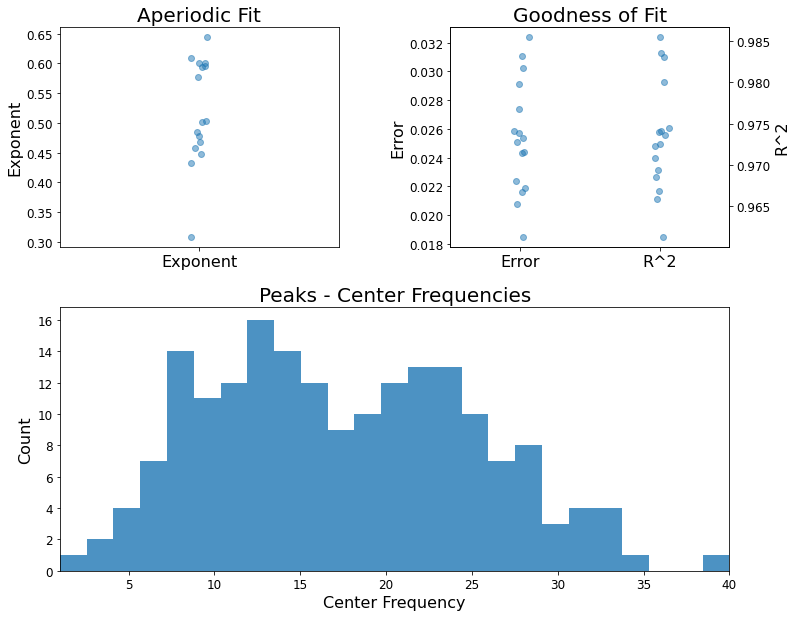

In [5]:
subject_path = 'data/parcellated_source_yeo7/sub-01_task-baseline1_labels.npz'

label_ts = np.load(subject_path)['labels']
  
# create a continuous data array from the parcellated source data
label_continious = np.hstack(np.array(label_ts))

# calculate psd on continuous data
psds, freqs = psd_array_welch(label_continious,
                            sfreq=sfreq,
                            fmin=1,
                            fmax=40,
                            n_fft=2048, # window size is 2048/512 = 4s
                            n_overlap=1024, # 50% overlap
                            n_jobs=1)

# initialize FOOOF group object
fg = FOOOFGroup(aperiodic_mode='fixed', # knee is 'fixed' to 0 as our frequency range is not greater than 40 Hz
            peak_width_limits=[1, 8], # minimum peak width is 1Hz, four time the frequency resolution (0.25Hz)
            min_peak_height=0.05,
            peak_threshold=2)

# fit model
fg.report(freqs, psds)